<a href="https://colab.research.google.com/github/predicthq/phq-data-science-docs/blob/master/unattended-events/part_2_data_exploration.ipynb" target="_blank"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### NON-ATTENDANCE-BASED EVENTS DATA SCIENCE GUIDES

# Part 2 Data Exploration
<b>A How To Guide to exploring PredictHQ's Non-Attendance-Based Events (public-holidays, observances and school-holidays).</b>

- [SDK or CSV Data Access](#csv_sdk)
- [Query Non-Attendance-Based Events](#query_unattended_events)
- [Overview of Non-Attendance-Based Events](#event_overview)
- [Event Label Statistics](#event_labels)
- [PHQ Rank and Aviation Rank](#ranks)
- [Duration](#duration)
- [First Seen Date](#first_seen_date_start_date)
- [Map Visualization](#visual_map)
- [Impact of Radius Settings](#radius_impact)
- [Comparing with Third Party Libraries](#comparing_with_third_party_libraries)
- [Forecasting Impact](#forecasting_impact)


If using Google Colab uncomment the following code block.

In [ ]:
# %%capture
# !git clone https://github.com/predicthq/phq-data-science-docs.git
# %cd phq-data-science-docs/unattended-events
# !pip install predicthq==1.6.3 timezonefinder calmap==0.0.9


If running locally, set up a Python environment using `requirements.txt` shared alongside the notebook to install the required dependencies. 



In [1]:
from predicthq import Client
from timezonefinder import TimezoneFinder
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px
import numpy as np
import pandas as pd
import folium
from datetime import timedelta
import calmap
import requests
import json

%matplotlib inline

# To display more columns in the DataFrame
pd.set_option("display.max_columns", 50)

<a id='csv_sdk'></a>
# SDK or CSV Data Access
This notebook can be run using both the csv example data provided, or if you have access to the PredictHQ Client endpoint, you can use the code provided to call the SDK for the locations of interest to you. 

The starting point for Part 2 is the dataset created at the end of Part 1. As using the SDK is not the focus of Part 2, a function is created to call the SDK. For guidance on how to use the SDK, please refer to Part 1. If you do not have access to the SDK, the notebook also works with a number of CSV files that are provided alongside the notebook. 

In [2]:
# Set whether to run with SDK or using provided CSV files
# Set to either 'CSV' or 'SDK'
RUN_SETTING = "CSV"

if RUN_SETTING == "SDK":
    # Replace Access Token with own access token.
    ACCESS_TOKEN = 'REPLACE_WITH_ACCESS_TOKEN'
    phq = Client(access_token=ACCESS_TOKEN)


def query_unattended_events(
    start_time,
    end_time,
    radius,
    radius_unit,
    latitude,
    longitude,
    categories,
):
    """
    Query Non-Attendance-Based Events based on time, location and category info.
    Args:
        start_time: start of the period for querying Non-Attendance-Based Events.
                    Format "YYYY-MM-DD"
        end_time: end of the period for querying Non-Attendance-Based Events.
                    Format of "YYYY-MM-DD"
        radius: radius for querying Non-Attendance-Based Events.
        radius_unit: unit of the radius.
        latitude: latitude of the interested location.
        longitude: longitude of the interested location.
        categories: list of categories, such as
                                    ['school-holidays',
                                    'public-holidays',
                                    'observances']
    return:
        event_df: pandas DataFrames of non-attendance-based events
    """
    within = f"{radius}{radius_unit}@{latitude},{longitude}"
    timezone = TimezoneFinder().timezone_at(lat=latitude, lng=longitude)

    params = {
        "active__gte": start_time,
        "active__lte": end_time,
        "active__tz": timezone,
        "within": within,
        "category": categories,
    }

    result_list = []

    # Iterating through all the events that match our criteria and
    # adding them to our result_list
    for event in phq.events.search(params).iter_all():
        result_list.append(event.to_dict())

    event_df = pd.DataFrame(result_list)
    # Selecting the target fields
    event_df = event_df[
        [
            "id",
            "title",
            "description",
            "start",
            "end",
            "duration",
            "category",
            "labels",
            "country",
            "rank",
            "aviation_rank",
            "location",
            "place_hierarchies",
            "scope",
            "first_seen",
        ]
    ]
    return event_df

<a id='query_unattended_events'></a>
# Query Non-Attendance-Based Events

In [3]:
start_time = "2020-01-01"
end_time = "2020-12-31"
radius = 10
radius_unit = "km"
latitude, longitude = (34.07, -118.25)
categories = ["school-holidays", "public-holidays", "observances"]
file_name = f"data/event_data/radius{radius}{radius_unit}_{latitude}_{longitude}_{start_time}_{end_time}.csv"

if RUN_SETTING == "SDK":
    event_df = query_unattended_events(
        start_time,
        end_time,
        radius,
        radius_unit,
        latitude,
        longitude,
        categories,
    )
    event_df.to_csv(file_name, index=False)
elif RUN_SETTING == "CSV":
    event_df = pd.read_csv(file_name)
    # convert string with python expression
    event_df["labels"] = event_df["labels"].apply(lambda x: eval(x))
    event_df["location"] = event_df["location"].apply(lambda x: eval(x))
else:
    print("Must set RUN_SETTING to either 'SDK' or 'CSV'")

event_df = event_df.sort_values("start")
event_df.head()

id                                title  \
338  8B2iGkAUVwMRPwWcvV  California - Winter School Holidays   
337        rxG7bJY3LgNJ                       New Year's Day   
336        1QNjLrLa9mYG                    World Braille Day   
335        x1Wq0aBvw14K                             Epiphany   
333        nRyQem18dL1B               Orthodox Christmas Day   

                                           description  \
338                                                NaN   
337  New Year's Day is the first day of the Gregori...   
336  World Braille Day celebrates the life and achi...   
335  Many people in the United States annually obse...   
333  Many Orthodox Christian churches in countries ...   

                         start                        end  duration  \
338  2019-12-21 00:00:00+00:00  2020-01-12 23:59:59+00:00   1987199   
337  2020-01-01 00:00:00+00:00  2020-01-01 23:59:59+00:00     86399   
336  2020-01-04 00:00:00+00:00  2020-01-04 23:59:59+00:00     86399   
335  2020-01-06 00:00:00+00:00  2020-01-06 23:59:59+00:00     86399   
333  2020-01-07 00:00:00+00:00  2020-01-07 23:59:59+00:00     86399   

            category                                             labels  \
338  school-holidays                                  [holiday, school]   
337  public-holidays                        [holiday, holiday-national]   
336      observances        [holiday, observance, observance-worldwide]   
335      observances  [holiday, holiday-christian, holiday-religious...   
333      observances  [holiday, holiday-orthodox, holiday-religious,...   

    country  rank  aviation_rank                  location  \
338      US    90            100  [-119.417932, 36.778261]   
337      US    90            100    [-95.712891, 37.09024]   
336      US    50              0    [-95.712891, 37.09024]   
335      US    50              0    [-95.712891, 37.09024]   
333      US    50              0    [-95.712891, 37.09024]   

                                  place_hierarchies    scope  \
338  [['6295630', '6255149', '6252001', '5332921']]   region   
337             [['6295630', '6255149', '6252001']]  country   
336             [['6295630', '6255149', '6252001']]  country   
335             [['6295630', '6255149', '6252001']]  country   
333             [['6295630', '6255149', '6252001']]  country   

                    first_seen  
338  2018-03-17 20:03:08+00:00  
337  2017-01-04 22:55:02+00:00  
336  2017-01-04 22:55:04+00:00  
335  2017-01-04 22:55:05+00:00  
333  2017-01-04 22:55:07+00:00

### Event Preprocessing

In [4]:
event_df["start"] = pd.to_datetime(event_df["start"])
event_df["start_date"] = event_df.start.map(lambda x: x.date())

event_df["first_seen"] = pd.to_datetime(event_df["first_seen"])
event_df["first_seen_date"] = event_df.first_seen.map(lambda x: x.date())

event_df["end"] = pd.to_datetime(event_df["end"])
event_df["end_date"] = event_df.end.map(lambda x: x.date())

event_df["duration_day"] = event_df.apply(
    lambda row: (row["end_date"] - row["start_date"]).days + 1, axis=1
)

event_df["day_from_first_seen"] = event_df.apply(
    lambda row: (row["end_date"] - row["first_seen_date"]).days + 1, axis=1
)

<a id='event_overview'></a>
# Overview of Non-Attendance-Based Events


#### Number of events per category

In [5]:
fig = go.Figure(
    data=[
        go.Pie(
            labels=event_df.groupby(["category"])["title"].count().index,
            values=event_df.groupby(["category"])["title"].count().values,
        )
    ]
)

fig.update_traces(hoverinfo="label+percent", textinfo="value", textfont_size=20)

fig.show()

#### Visualize the number of events per day

In [6]:
event_split = []

for _, row in event_df.iterrows():
    start_date = row["start"].date()
    end_date = row["end"].date()
    delta = (end_date - start_date).days + 1

    for i in range(delta):
        event_split.append(
            {
                "date": start_date + timedelta(days=i),
                "id": row["id"],
                "title": row["title"],
                "labels": row["labels"],
                "category": row["category"],
                "rank": row["rank"],
                "aviation_rank": row["aviation_rank"],
                "start": row["start"],
                "end": row["end"],
            }
        )

event_split = pd.DataFrame(event_split)

event_split_count = (
    event_split.groupby(["date", "category"])[["rank"]]
    .count()
    .rename(columns={"rank": "count"})
    .reset_index()
)

event_split_count = event_split_count.pivot(
    index="date", columns="category", values="count"
).fillna(0)

event_count_per_day = pd.DataFrame(index=pd.date_range(start=start_time, end=end_time))

event_count_per_day = pd.merge(
    event_count_per_day,
    event_split_count,
    how="left",
    left_index=True,
    right_index=True,
).fillna(0)

fig = make_subplots(rows=3, cols=1, shared_xaxes=True)

fig.add_trace(
    go.Scatter(
        x=event_count_per_day.index,
        y=event_count_per_day["public-holidays"],
        name="public-holidays",
        mode="lines+markers",
    ),
    row=1,
    col=1,
)

fig.add_trace(
    go.Scatter(
        x=event_count_per_day.index,
        y=event_count_per_day["observances"],
        name="observances",
        mode="lines+markers",
    ),
    row=2,
    col=1,
)

fig.add_trace(
    go.Scatter(
        x=event_count_per_day.index,
        y=event_count_per_day["school-holidays"],
        name="school-holidays",
        mode="lines+markers",
    ),
    row=3,
    col=1,
)

fig.update_layout(
    title="Number of events per day",
    title_x=0.45,
    yaxis=dict(
        title="count", range=[0, event_count_per_day["public-holidays"].max() * 1.1]
    ),
    yaxis2=dict(
        title="count", range=[0, event_count_per_day["observances"].max() * 1.1]
    ),
    yaxis3=dict(
        title="count", range=[0, event_count_per_day["school-holidays"].max() * 1.1]
    ),
)

fig.show()

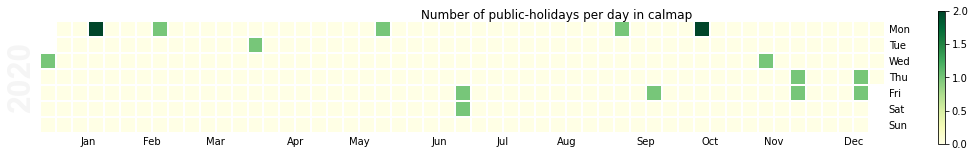

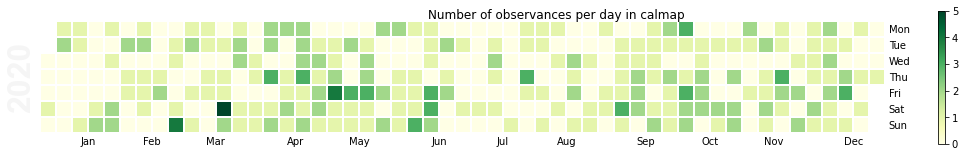

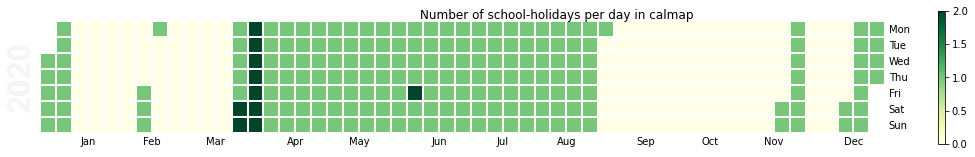

In [7]:
fig, ax = calmap.calendarplot(event_count_per_day["public-holidays"], cmap="YlGn")
fig.set_size_inches(18, 2)
fig.colorbar(ax[0].get_children()[1], ax=ax.ravel().tolist())
_ = fig.suptitle("Number of public-holidays per day in calmap")

fig, ax = calmap.calendarplot(event_count_per_day["observances"], cmap="YlGn")
fig.set_size_inches(18, 2)
fig.colorbar(ax[0].get_children()[1], ax=ax.ravel().tolist())
_ = fig.suptitle("Number of observances per day in calmap")

fig, ax = calmap.calendarplot(event_count_per_day["school-holidays"], cmap="YlGn")
fig.set_size_inches(18, 2)
fig.colorbar(ax[0].get_children()[1], ax=ax.ravel().tolist())
_ = fig.suptitle("Number of school-holidays per day in calmap")


#### Top Three days 
The three days in the dataset with the most events.

In [8]:
days_with_multiple_events = (
    event_df.groupby("start")
    .count()[["id"]]
    .sort_values("id", ascending=False)[:3]
    .index
)

event_df[event_df.start.isin(days_with_multiple_events)].groupby(
    ["start_date", "title"]
).count()[
    []
]  # return empty columns since only indexes are interested

Empty DataFrame
Columns: []
Index: [(2020-03-01, First Day of Women's History Month), (2020-03-01, Self-Injury Awareness Day), (2020-03-01, St. David's Day), (2020-03-01, Zero Discrimination Day), (2020-03-21, International Day for the Elimination of Racial Discrimination), (2020-03-21, International Day of Forests), (2020-03-21, International Day of Nowruz), (2020-03-21, World Down Syndrome Day), (2020-03-21, World Poetry Day), (2020-05-08, Military Spouse Appreciation Day), (2020-05-08, Time of Remembrance and Reconciliation for Those Who Lost Their Lives during the Second World War), (2020-05-08, Victory in Europe Day), (2020-05-08, World Ovarian Cancer Day)]

<a id='event_labels'></a>
# Event Label Statistics
Each event is associated with a label. Depending on your business domain, events associated with certain labels may be more or less important.

In [9]:
event_df[["title", "description", "start", "end", "labels"]].head()

title  \
338  California - Winter School Holidays   
337                       New Year's Day   
336                    World Braille Day   
335                             Epiphany   
333               Orthodox Christmas Day   

                                           description  \
338                                                NaN   
337  New Year's Day is the first day of the Gregori...   
336  World Braille Day celebrates the life and achi...   
335  Many people in the United States annually obse...   
333  Many Orthodox Christian churches in countries ...   

                        start                       end  \
338 2019-12-21 00:00:00+00:00 2020-01-12 23:59:59+00:00   
337 2020-01-01 00:00:00+00:00 2020-01-01 23:59:59+00:00   
336 2020-01-04 00:00:00+00:00 2020-01-04 23:59:59+00:00   
335 2020-01-06 00:00:00+00:00 2020-01-06 23:59:59+00:00   
333 2020-01-07 00:00:00+00:00 2020-01-07 23:59:59+00:00   

                                                labels  
338                                  [holiday, school]  
337                        [holiday, holiday-national]  
336        [holiday, observance, observance-worldwide]  
335  [holiday, holiday-christian, holiday-religious...  
333  [holiday, holiday-orthodox, holiday-religious,...

In [10]:
label_all = []

for labels in event_df["labels"].to_list():
    label_all.extend(labels)

bins, counts = np.unique(label_all, return_counts=True)

fig = px.bar(x=bins, y=counts, labels={"x": "label", "y": "count"})

fig.update_layout(
    yaxis_type="log",
    title="Frequency of Each Label",
    title_x=0.45,
)

fig.show()

The label information is helpful for understanding the difference between events from each category. For example, the events from *observances* could be further grouped by whether it is a worldwide event or not. With this level of granularity, you can prioritize events from particular labels. 

<a id='ranks'></a>
# PHQ Rank and Aviation Rank

Each Non-Attendance-Based Event has both PHQ Rank and Aviation Rank.

In [11]:
event_df.groupby(["category", "rank"]).count()[["title"]].rename(
    columns={"title": "count"}
)

count
category        rank       
observances     50      312
                90        3
public-holidays 70        5
                90       12
school-holidays 90        7

Event label and duration are the two main factors for estimating the Aviation Rank. 

In [12]:
event_df.groupby(["category", "aviation_rank"]).count()[["title"]].rename(
    columns={"title": "count"}
)

count
category        aviation_rank       
observances     0                315
public-holidays 0                  5
                100               12
school-holidays 0                  3
                100                4

<a id='duration'></a>
# Duration
Most of the events have one day duration. School holidays usually have multiple days duration.

In [13]:
fig = px.histogram(
    event_df,
    x="duration_day",
    marginal="box",  # can be 'rug' `box`, `violin`
    hover_data=["id", "title", "category", "labels"],
    nbins=50,
)

fig.update_layout(
    yaxis_type="log",
    title_text="Duration of Events",  # title of plot
    title_x=0.5,
    xaxis_title_text="days",  # xaxis label
    yaxis_title_text="count",  # yaxis label
    bargap=0.2,  # gap between bars of adjacent location coordinates
    bargroupgap=0.1,  # gap between bars of the same location coordinates
)

fig.show()

#### Events with Multiple Day Duration

In [14]:
event_df[event_df.duration_day > 1][["title", "start", "end", "category"]]

title                     start  \
338        California - Winter School Holidays 2019-12-21 00:00:00+00:00   
310    California - Mid-Winter School Holidays 2020-02-14 00:00:00+00:00   
276       California School Closure (Covid-19) 2020-03-23 00:00:00+00:00   
271        California - Spring School Holidays 2020-03-28 00:00:00+00:00   
181        California - Summer School Holidays 2020-06-12 00:00:00+00:00   
38   California - Thanksgiving School Holidays 2020-11-21 00:00:00+00:00   
7          California - Winter School Holidays 2020-12-19 00:00:00+00:00   

                          end         category  
338 2020-01-12 23:59:59+00:00  school-holidays  
310 2020-02-17 23:59:59+00:00  school-holidays  
276 2020-06-12 23:59:59+00:00  school-holidays  
271 2020-04-05 23:59:59+00:00  school-holidays  
181 2020-08-31 23:59:59+00:00  school-holidays  
38  2020-11-29 23:59:59+00:00  school-holidays  
7   2021-01-03 23:59:59+00:00  school-holidays

<a id='first_seen_date_start_date'></a>
# First Seen Date

Each event has the first_seen_date field which is the time when we have this record. Here are the stats of first seen date of Non-Attendance-Based Events:

In [15]:
event_df.groupby(["first_seen_date"]).count()[["id"]].rename(
    columns={"id": "count"}
).sort_values("count", ascending=False)

count
first_seen_date       
2017-01-04         286
2017-05-11          12
2018-03-17           3
2019-01-21           3
2020-09-30           2
2020-03-13           2
2017-01-11           2
2018-10-17           2
2018-11-28           2
2017-05-18           2
2018-03-21           1
2018-03-28           1
2020-09-26           1
2020-09-10           1
2020-07-10           1
2020-06-16           1
2020-05-06           1
2020-04-15           1
2020-03-29           1
2017-06-10           1
2020-02-12           1
2019-12-11           1
2019-08-21           1
2019-07-17           1
2017-09-13           1
2018-12-19           1
2017-09-20           1
2018-11-21           1
2018-10-24           1
2018-02-08           1
2018-07-04           1
2018-04-25           1
2020-12-23           1

#### Stats of days before the first time seen

Based on the first_seen_date and the start time of the events, we could estimate how many days we could know before the event starts. 

In [16]:
fig = px.histogram(
    event_df,
    x="day_from_first_seen",
    marginal="box",  # can be 'rug' `box`, `violin`
    hover_data=["id", "title", "category", "labels"],
    nbins=50,
)

fig.update_layout(
    title_text="Number of days between first time seen and start_time",  # title of plot
    title_x=0.5,
    xaxis_title_text="Days before the",  # xaxis label
    yaxis_title_text="Count",  # yaxis label
    bargap=0.2,  # gap between bars of adjacent location coordinates
    bargroupgap=0.1,  # gap between bars of the same location coordinates
)

fig.show()

From the histogram, we could see that the majority Non-Attendance-Based Events were listed 3 to 4 years before events started. The main reason is the majority of Non-Attendance-Based Events were listed on 2017-01-04.
We also found three events that were listed after the start date. 

#### Events which was recorded after it was happened

In [17]:
event_df[event_df.day_from_first_seen < 0][
    [
        "title",
        "start",
        "end",
        "category",
        "first_seen",
        "day_from_first_seen",
    ]
]

title  \
322                 First Day of Black History Month   
300               First Day of Women's History Month   
259  National Former Prisoner of War Recognition Day   

                        start                       end     category  \
322 2020-02-01 00:00:00+00:00 2020-02-01 23:59:59+00:00  observances   
300 2020-03-01 00:00:00+00:00 2020-03-01 23:59:59+00:00  observances   
259 2020-04-09 00:00:00+00:00 2020-04-09 23:59:59+00:00  observances   

                   first_seen  day_from_first_seen  
322 2020-02-12 00:00:01+00:00                  -10  
300 2020-03-13 00:05:56+00:00                  -11  
259 2020-04-15 00:01:11+00:00                   -5

<a id='visual_map'></a>
# Map Visualization

Non-Attendance-Based Events generally have a large location scope. There are two unique locations for the above events. The two locations represent events that are country wide, and events that are state wide.

#### Stats of events from different locations

In [18]:
def place_id_to_location_name(place_id):
    """
    Convert place_id to location name
    """
    response = requests.get(
        url="https://api.predicthq.com/v1/places/",
        headers={
            "Authorization": "Bearer {}".format(ACCESS_TOKEN),
            "Accept": "application/json",
        },
        params={"id": place_id},
    )

    data = response.json()
    df = pd.json_normalize(data["results"])
    return df.iloc[0]["name"]


event_df["place_hierarchies"] = event_df["place_hierarchies"].apply(lambda x: str(x))

event_df_place_id = (
    event_df.groupby(["place_hierarchies"])
    .count()[["id"]]
    .rename(columns={"id": "count"})
    .reset_index()
)

file_name = f"data/place_id_{latitude}_{longitude}_{start_time}_{end_time}.csv"

if RUN_SETTING == "SDK":
    event_df_place_id["location"] = event_df_place_id.place_hierarchies.apply(
        lambda x: place_id_to_location_name(eval(x)[-1])
    )

    event_df_place_id.to_csv(file_name, index=False)
    display(event_df_place_id[["location", "place_hierarchies", "count"]])
else:
    event_df_place_id = pd.read_csv(file_name)
    display(event_df_place_id[["location", "place_hierarchies", "count"]])


location                               place_hierarchies  count
0     California  [['6295630', '6255149', '6252001', '5332921']]     18
1  United States             [['6295630', '6255149', '6252001']]    321

#### Visualization of locations in map

In [19]:
style1 = {"fillColor": "#228B22", "color": "#228B22"}
style2 = {"fillColor": "#226a8b", "color": "#226a8b"}
# Default location for folium map visualization
lat_folium, lon_folium = 37.0902, -95.7129
# Location for state such as California
lat_state, lon_state = 36.778261, -119.417932
state_name = "California"
# Location for a country such as USA
lat_country, lon_country = 37.09024, -95.712891
country_name = "USA"

m = folium.Map(location=[lat_folium, lon_folium], zoom_start=4.2)
# Add polygon for California
with open("data/geo_data/us-state-boundaries.geojson") as f:
    states = json.load(f)
with open("data/geo_data/countries.geojson") as f:
    countries = json.load(f)

res_state = []

for i in states["features"]:
    if i["properties"]["name"] == state_name:
        res_state.append(i)

polygon1 = states.copy()
polygon1["features"] = res_state

res_country = []

for i in countries["features"]:
    if i["properties"]["ISO_A3"] == country_name:
        res_country.append(i)

polygon2 = countries.copy()
polygon2["features"] = res_country

m = folium.Map(location=[lat_folium, lon_folium], zoom_start=4.2)

folium.Marker(
    location=[lat_state, lon_state],
    popup=state_name,
    icon=folium.Icon(color="green"),
).add_to(m)

folium.GeoJson(polygon1, name=state_name, style_function=lambda x: style1).add_to(m)

folium.Marker(
    location=[lat_country, lon_country],
    popup=country_name,
    icon=folium.Icon(color="blue"),
).add_to(m)

folium.GeoJson(polygon2, name=country_name, style_function=lambda x: style2).add_to(m)

folium.LayerControl().add_to(m)

m

#### Visualize Non-Attendance-Based Events for different regions

Holiday info from neighbouring regions is useful for evaluating the impact of Non-Attendance-Based Events of the day. We use the US as an example. For a given day and specified categories, a map is used to show whether each state has Non-Attendance-Based Events. 

In [20]:
def non_attendance_based_event_state(
    date,
    categories=None
):
    """
    Check whether there are Non-Attendance-Based Events for each state. The visualization is only for UD states
    Args:
        date: The date which is interested for checking
                    Format "YYYY-MM-DD"
        categories: list of categories, such as
                                    ['school-holidays',
                                    'public-holidays',
                                    'observances']
    return:
        state_holiday_indicator: dictionary where the keys are the state name and the value indicates whether it has
                                 Non-Attendance-Based Events for specific day
    """

    if categories is None:
        categories = ['school-holidays', 'public-holidays', 'observances']

    parameters_dict = dict()
    parameters_dict.update(active__gte=date)
    parameters_dict.update(active__lte=date)
    parameters_dict.update(category=categories)

    state_holiday_indicator = {}

    for i in states["features"]:
        state = i["properties"]["name"]
        response = requests.get(
            url="https://api.predicthq.com/v1/places/",
            headers={
                "Authorization": "Bearer {}".format(ACCESS_TOKEN),
                "Accept": "application/json",
            },
            params={"q": state, "type": "region"},
        )

        data = response.json()
        df = pd.json_normalize(data["results"])
        place_id = [int(df.iloc[0]["id"])]
        parameters_dict.update(place__scope=place_id)
        result_list = []

        # Iterating through all the events that match our criteria and adding them to our result_list
        for event in phq.events.search(parameters_dict).iter_all():
            result_list.append(event.to_dict())

        if len(result_list) > 0:
            state_holiday_indicator[state] = 1
        else:
            state_holiday_indicator[state] = 0

    return state_holiday_indicator


date_map = "2020-02-17"
categories_date = ["public-holidays"]
file_name = f"data/state_holiday_indicator_{date_map}_{'_'.join(categories_date)}.csv"

if RUN_SETTING == "SDK":
    state_holiday_indicator = non_attendance_based_event_state(
        date_map, categories_date
    )
    pd.DataFrame([state_holiday_indicator]).to_csv(
        file_name, index=False
    )
else:
    state_holiday_indicator = (
        pd.read_csv(file_name).T[0].to_dict()
    )


In [21]:
def state_to_color(feature):
    style = styles[state_holiday_indicator[feature["properties"]["name"]]]
    return style


style0 = {"fillColor": "#6da895", "color": "#6da895"}
style1 = {"fillColor": "#2e07f2", "color": "#2e07f2"}
styles = {0: style0, 1: style1}

m = folium.Map(location=[lat_folium, lon_folium], zoom_start=4.2)

folium.Marker(
    location=[latitude, longitude],
    popup="Los Angeles",
    icon=folium.Icon(color="green"),
).add_to(m)

folium.GeoJson(
    states,
    name="California",
    style_function=lambda feature: state_to_color(feature),
).add_to(m)

folium.LayerControl().add_to(m)

m

For the above example, the event info is for the day of ```2020-02-17``` and the category of ```public-holidays```. The pin shows the location of interest in Los Angeles. The states with blue color means they have ```public-holidays``` events on that day. The states with light green color means they do not have ```public-holidays``` events on that day. For states with ```public-holidays``` events, the holiday event is ```Presidents' Day```. The visualization means that most of the states have ```public-holidays``` events on ```Presidents' Day```.

<a id='radius_impact'></a>
# Impact of Radius Settings

Events info is summarized for a range of radius 1km, 2km, 4km, 8km, 16km, 32km, 64km, 128, 256km, 512km and 1024km.

In [22]:
# Results of stats for different radius
res_stat = []
# Results of DataFrame for different radius
res_df = []
start_time = "2020-01-01"
end_time = "2020-12-31"
radius_unit = "km"
latitude, longitude = (34.07, -118.25)
categories = ["school-holidays", "public-holidays", "observances"]

for radius_impact in [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]:
    file_name = f"data/event_data/radius{radius_impact}{radius_unit}_{latitude}_{longitude}_{start_time}_{end_time}.csv"

    if RUN_SETTING == "SDK":
        event_df_radius = query_unattended_events(
            start_time,
            end_time,
            radius_impact,
            radius_unit,
            latitude,
            longitude,
            categories,
        )

        event_df_radius.to_csv(
            file_name,
            index=False,
        )

        # Convert to string since list not hashable.
        event_df_radius["place_hierarchies"] = event_df_radius[
            "place_hierarchies"
        ].apply(lambda x: str(x))
    else:
        event_df_radius = pd.read_csv(file_name)

    stat = event_df_radius.groupby(["category"])["title"].count().to_dict()
    stat["radius"] = radius_impact
    res_stat.append(stat)

    event_df_radius["radius"] = f"{radius_impact}{radius_unit}"
    res_df.append(event_df_radius)

res_stat = pd.DataFrame(res_stat)

fig = go.Figure()

fig.add_trace(go.Scatter(x=res_stat.radius, y=res_stat.observances, name="observances"))

fig.add_trace(
    go.Scatter(x=res_stat.radius, y=res_stat["public-holidays"], name="public-holidays")
)

fig.add_trace(
    go.Scatter(x=res_stat.radius, y=res_stat["school-holidays"], name="school-holidays")
)

fig.update_layout(
    xaxis_type="log",
    yaxis_type="log",
    title="Number of events for different radius",
    title_x=0.45,
    xaxis=dict(
        title="radius (km)",
    ),
    yaxis=dict(
        title="count",
    ),
)

fig.show()

In [23]:
m = folium.Map(location=[latitude, longitude], zoom_start=4.2)
folium.Marker(location=[latitude, longitude]).add_to(m)

for radius_impact in [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]:
    folium.Circle(
        [latitude, longitude],
        radius=radius_impact * 1000,
        tooltip=f"{radius_impact}{radius_unit}",
    ).add_to(m)

m

##### Stats of events per radius setting

In [24]:
file_name = f"data/radius_pivot_{latitude}_{longitude}_{start_time}_{end_time}.csv"

if RUN_SETTING == "SDK":
    event_df_radius_all = pd.concat(res_df)[
        ["title", "place_hierarchies", "radius", "category"]
    ]
    
    event_df_radius_all_count = (
        event_df_radius_all.groupby(["radius", "place_hierarchies"])
        .count()[["title"]]
        .rename(columns={"title": "count"})
        .reset_index()
    )

    event_df_radius_all_count[
        "location"
    ] = event_df_radius_all_count.place_hierarchies.apply(
        lambda x: place_id_to_location_name(eval(x)[-1])
    )

    radius_column = [
        f"{radius_impact}{radius_unit}"
        for radius_impact in [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]
    ]
    
    event_df_radius_all_count_pivot = (
        event_df_radius_all_count.pivot(
            index="location", columns="radius", values="count"
        )
        .fillna(0)[radius_column]
        .sort_values(radius_column, ascending=False)
    )
    
    event_df_radius_all_count_pivot.to_csv(
        file_name
    )
    
    display(event_df_radius_all_count_pivot.astype(int))
else:
    event_df_radius_all_count_pivot = pd.read_csv(
        file_name
    )
    
    display(event_df_radius_all_count_pivot.set_index("location").astype(int))


1km  2km  4km  8km  16km  32km  64km  128km  256km  512km  \
location                                                                   
United States  321  321  321  321   321   321   321    321    321    321   
California      18   18   18   18    18    18    18     18     18     18   
Utah             0    0    0    0     0     0     0      0      0      0   
Arizona          0    0    0    0     0     0     0      0      0      0   
Nevada           0    0    0    0     0     0     0      0      0      0   

               1024km  
location               
United States     321  
California         18  
Utah               17  
Arizona            14  
Nevada             14

#### Additional events for radius 1024

In [25]:
event_df_radius_512km = res_df[-2]
event_df_radius_1024km = res_df[-1]
event_df_radius = pd.concat([event_df_radius_512km, event_df_radius_1024km])[
    [
        "id",
        "title",
        "description",
        "start",
        "end",
        "duration",
        "category",
        "country",
        "place_hierarchies",
        "rank",
        "aviation_rank",
    ]
]

event_df_radius.drop_duplicates(keep=False)[
    ["id", "title", "start", "end", "category", "place_hierarchies"]
]

id                                  title  \
7    SsEyR8ChVxksACvEuF          Utah - Winter School Holidays   
8    TGHft7tPWv46sxymtJ    Arizona - Christmas School Holidays   
11   j9sWsbFCJ75eF9Kufo        Nevada - Winter School Holidays   
13         o2X0QQ1q2Y11             International Migrants Day   
39   rwFciChCgEK4BTi2A5                             Family Day   
40   v3TZGdgfstN9cJinc5    Utah - Thanksgiving School Holidays   
43   5xpsAaMPESSoxs5oWg  Nevada - Thanksgiving School Holidays   
69         rRqxD6WgAwBE                             Nevada Day   
81   CUpZjYyVjF97pxfoWa          Utah - Autumn School Holidays   
86   c8viFTCsnFZQdFAT6F                           Columbus Day   
89   8r6BRNwTpPXMMrDrwf                Indigenous People's Day   
92   6uAUiZUzwp5ZE2WUBH                           Columbus Day   
106  YNjqYZsk4nesZoR7Td       Arizona - Autumn School Holidays   
118  E2EKMwpmcKkyvWsMmo                    Native American Day   
166        7bPxJpMx8bDK                            Pioneer Day   
187  nN3j9kmhQ4ZKhhmVdh                             Juneteenth   
188        Lk3qMlPQnvep                             Juneteenth   
205  E6KdhAqv3XjjrwBTvU        Nevada - Summer School Holidays   
207  oStW5KDPq9kA4nNUY9          Utah - Summer School Holidays   
209  5L39hHVN3jzTYks8kq                    Native American Day   
220  ZkzkFkGz4ginnMssrT       Arizona - Summer School Holidays   
235  z2dSwi67zmrp2fgZdZ     Last Day of Stay at Home Directive   
252  DNsmfCHdh7vcSfiTyE     Last Day of Stay at Home Directive   
292  r4yGQDuD9xXLY8EYT9                       César Chávez Day   
293  3ANHbqV4ptQiVqprGC                       César Chávez Day   
295  pR7VaPU3gKx6S7Ae3j                       César Chávez Day   
299  wFzARfziS5Sq8exAfv    First Day of Stay at Home Directive   
308  kiFrwJrYYrBeS9R5A5          Utah - Spring School Holidays   
315  bDWL3Ft9tAsmNA7cfW    First Day of Stay at Home Directive   
318  QpXasbZ2ghVt4EvdwL         Utah School Closure (Covid-19)   
319  xnHNZYQNH6a47EmqkJ       Nevada School Closure (Covid-19)   
320  dUC4wHt58zFRqmYvyk      Arizona School Closure (Covid-19)   
321  XAepVmGz7sVEpwzTtx        Nevada - Spring School Holidays   
327  YfgypdCkGoDNzcP5gj       Arizona - Spring School Holidays   
331  9rYYUBXEBfU5rqbrq6                          Super Tuesday   
343  qkf3MzR23S4wQqnuFF                        Presidents' Day   
345  DCXYagJdnMcqZQiZjp                        Presidents' Day   
346  KMLfSyHSX7EgXQxGxd                        Presidents' Day   
348        qe91JOgnMwod                          Statehood Day   
369        7q9GYLk0ze78                       Civil Rights Day   
378  m3wiMCEVu9kdEB4qBg                          Statehood Day   
381  MjPN3y57fPENMyz74T    Arizona - Christmas School Holidays   
382  z5haJgJQ468HhsNzFp          Utah - Winter School Holidays   
383  qNLaXK3kaCQ4oPSqzD        Nevada - Winter School Holidays   

                         start                        end         category  \
7    2020-12-19 00:00:00+00:00  2021-01-03 23:59:59+00:00  school-holidays   
8    2020-12-19 00:00:00+00:00  2021-01-03 23:59:59+00:00  school-holidays   
11   2020-12-18 00:00:00+00:00  2021-01-03 23:59:59+00:00  school-holidays   
13   2020-12-18 00:00:00+00:00  2020-12-18 23:59:59+00:00      observances   
39   2020-11-27 00:00:00+00:00  2020-11-27 23:59:59+00:00  public-holidays   
40   2020-11-26 00:00:00+00:00  2020-11-29 23:59:59+00:00  school-holidays   
43   2020-11-25 00:00:00+00:00  2020-11-29 23:59:59+00:00  school-holidays   
69   2020-10-30 00:00:00+00:00  2020-10-30 23:59:59+00:00  public-holidays   
81   2020-10-15 00:00:00+00:00  2020-10-18 23:59:59+00:00  school-holidays   
86   2020-10-12 00:00:00+00:00  2020-10-12 23:59:59+00:00  public-holidays   
89   2020-10-12 00:00:00+00:00  2020-10-12 23:59:59+00:00  public-holidays   
92   2020-10-12 00:00:00+00:00  2020-10-12 23:59:59+00:00  public-holidays   
106  2020-10-03 00:00:00+00:00  2020

From above results, we can see that the additional events are coming from Nevada, Arizona and Utah states. Thus, when the radius increases until it has overlap with neighbouring states, the events from neighbouring states will be included.

<a id='comparing_with_third_party_libraries'></a>
# Comparing with Third Party Libraries

Holiday info from three third party libraries has been compared with events from the PredictHQ public-holidays category.

### Holiday from Pandas
Pandas has the ability for us to check whether a particular day is a holiday.

In [26]:
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

dr = pd.date_range(start="2020-01-01", end="2020-12-31")
holiday_pandas = pd.DataFrame()
holiday_pandas["Date"] = dr

cal = calendar()
holidays = cal.holidays(start=dr.min(), end=dr.max())

holiday_pandas["Holiday"] = holiday_pandas["Date"].isin(holidays)
holiday_pandas[holiday_pandas.Holiday]

Date  Holiday
0   2020-01-01     True
19  2020-01-20     True
47  2020-02-17     True
145 2020-05-25     True
184 2020-07-03     True
250 2020-09-07     True
285 2020-10-12     True
315 2020-11-11     True
330 2020-11-26     True
359 2020-12-25     True

### Holidays from Facebook Prophet
Modelling the impact of holidays on time series data is an important component in Prophet. Inside Prophet, the holiday information is provided by the *holidays* package in Python, but the holiday information is only available at the country level.

In [27]:
from fbprophet.make_holidays import make_holidays_df

holiday_prophet = make_holidays_df(year_list=[2020], country="US")
holiday_prophet

ds                      holiday
0  2020-01-01               New Year's Day
1  2020-01-20   Martin Luther King Jr. Day
2  2020-02-17        Washington's Birthday
3  2020-05-25                 Memorial Day
4  2020-07-04             Independence Day
5  2020-07-03  Independence Day (Observed)
6  2020-09-07                    Labor Day
7  2020-10-12                 Columbus Day
8  2020-11-11                 Veterans Day
9  2020-11-26                 Thanksgiving
10 2020-12-25                Christmas Day

### Holidays From Python
The *holidays* package in Python provides holiday information. For example, it provides holiday information for each state in the US.

In [28]:
import holidays

holiday_holidays = []
for date, name in sorted(holidays.US(state="CA", years=2020).items()):
    holiday_holidays.append({"date": date, "holiday_holidays": name})

holiday_holidays = pd.DataFrame(holiday_holidays)
holiday_holidays

date             holiday_holidays
0   2020-01-01               New Year's Day
1   2020-01-20   Martin Luther King Jr. Day
2   2020-02-15         Susan B. Anthony Day
3   2020-02-17        Washington's Birthday
4   2020-03-31             César Chávez Day
5   2020-05-25                 Memorial Day
6   2020-07-03  Independence Day (Observed)
7   2020-07-04             Independence Day
8   2020-09-07                    Labor Day
9   2020-10-12                 Columbus Day
10  2020-11-11                 Veterans Day
11  2020-11-26                 Thanksgiving
12  2020-11-27       Day After Thanksgiving
13  2020-12-25                Christmas Day

### The *public-holidays* info from PredictHQ

In [29]:
event_df[event_df.category == "public-holidays"].sort_values("start")[
    ["title", "start", "end", "rank", "aviation_rank"]
]

title                     start  \
337              New Year's Day 2020-01-01 00:00:00+00:00   
329    Robert E. Lee's Birthday 2020-01-20 00:00:00+00:00   
328  Martin Luther King Jr. Day 2020-01-20 00:00:00+00:00   
307             Presidents' Day 2020-02-17 00:00:00+00:00   
268            César Chávez Day 2020-03-31 00:00:00+00:00   
195                Memorial Day 2020-05-25 00:00:00+00:00   
159   Independence Day observed 2020-07-03 00:00:00+00:00   
157            Independence Day 2020-07-04 00:00:00+00:00   
124                   Labor Day 2020-09-07 00:00:00+00:00   
103         Native American Day 2020-09-25 00:00:00+00:00   
79      Indigenous People's Day 2020-10-12 00:00:00+00:00   
78                 Columbus Day 2020-10-12 00:00:00+00:00   
52                 Veterans Day 2020-11-11 00:00:00+00:00   
36             Thanksgiving Day 2020-11-26 00:00:00+00:00   
34       Day After Thanksgiving 2020-11-27 00:00:00+00:00   
4                 Christmas Eve 2020-12-24 00:00:00+00:00   
2                 Christmas Day 2020-12-25 00:00:00+00:00   

                          end  rank  aviation_rank  
337 2020-01-01 23:59:59+00:00    90            100  
329 2020-01-20 23:59:59+00:00    70              0  
328 2020-01-20 23:59:59+00:00    90            100  
307 2020-02-17 23:59:59+00:00    90            100  
268 2020-03-31 23:59:59+00:00    70              0  
195 2020-05-25 23:59:59+00:00    90            100  
159 2020-07-03 23:59:59+00:00    90            100  
157 2020-07-04 23:59:59+00:00    90            100  
124 2020-09-07 23:59:59+00:00    90            100  
103 2020-09-25 23:59:59+00:00    70              0  
79  2020-10-12 23:59:59+00:00    70              0  
78  2020-10-12 23:59:59+00:00    90            100  
52  2020-11-11 23:59:59+00:00    90            100  
36  2020-11-26 23:59:59+00:00    90            100  
34  2020-11-27 23:59:59+00:00    70              0  
4   2020-12-24 23:59:59+00:00    90            100  
2   2020-12-25 23:59:59+00:00    90            100

### The holidays provided by the above libraries are summarized in the following table.

date |pandas |fbprophet | holidays | *public-holidays* (PredictHQ)
:-----:|:-----:|:-----:|:-----:|:-----:
2020-01-01|$\surd$|$\surd$|$\surd$|$\surd$
2020-01-20|$\surd$|$\surd$|$\surd$|$\surd$
2020-02-15|$\times$|$\times$|$\surd$|$\surd$
2020-02-17|$\surd$|$\surd$|$\surd$|$\surd$
2020-03-31|$\times$|$\times$|$\surd$|$\surd$
2020-05-25|$\surd$|$\surd$|$\surd$|$\surd$
2020-07-03|$\surd$|$\surd$|$\surd$|$\surd$
2020-07-04|$\times$|$\surd$|$\surd$|$\surd$
2020-09-07|$\surd$|$\surd$|$\surd$|$\surd$
2020-09-25|$\times$|$\times$|$\times$|$\surd$
2020-10-12|$\surd$|$\surd$|$\surd$|$\surd$
2020-11-11|$\surd$|$\surd$|$\surd$|$\surd$
2020-11-26|$\surd$|$\surd$|$\surd$|$\surd$
2020-11-27|$\times$|$\times$|$\surd$|$\surd$
2020-12-24|$\times$|$\times$|$\times$|$\surd$
2020-12-25|$\surd$|$\surd$|$\surd$|$\surd$

From the above table, we can see the events from *public-holidays* have a wider coverage than the holiday information from other libraries. 

In addition to  *public-holidays*, PredictHQ's Non-Attendance-Based Events also include events from *observances* and *school-holidays*. For the dataset used previously, PredictHQ has $\frac{7+17+315}{15}=22.6$ times more events than the holiday events from the *holidays* package. 

PredictHQ also provides additional rank information to indicate the impact of these events. 

<a id='forecasting_impact'></a>
# Forecasting Impact

Within this notebook, we've gained a better understanding of PredictHQ's Non-Attendance-Based Events (public-holidays, observances and school-holidays).

By using this information we can make better decisions about how to incorporate these data points into forecasting.

Here's a summary of some of the key take-ways from each section. 

- [Overview of Non-Attendance-Based Events](#event_overview)
Of the three categories, observances make up the largest proportion of events. Although school-holidays make up a smaller proportion of the events, these events are usually multi-day events.

- [Event Label Statistics](#event_labels)
Event labels help to provide more detailed understanding of the type of events happening and make it easier to filter for events relevant to your business.

- [PHQ Rank and Local Rank](#ranks)
Rank information indicates the events impact. Aviation Rank indicates the impact on air travel. 

- [Duration](#duration)
School-holidays are the longest events. Most observances are 1 day events.

- [First Seen Date](#first_seen_date_start_date)
Most of the Non-Attendance-Based Events are known much earlier than they are happening. This is important for utilizing Non-Attendance-Based Events in forecasting models. 

- [Map Visualization](#visual_map)
The location of Non-Attendance-Based Events shows these events generally have a large scope. Some events will be at the country level with others at the state level (US).

- [Impact of Radius Settings](#radius_impact)
For business that would be impacted by events from neighbouring regions, the events could be extracted by setting the radius to be a relatively large value.

- [Comparing with Third Party Libraries](#comparing_with_third_party_libraries)
PredictHQ's *public-holidays* has significantly better coverage than other commonly used packages.